## Import packages

In [160]:
import sys
print(sys.version)  # Print Python version in use

import numpy as np                                   # Array operations
import matplotlib.pyplot as plt                      # Plotting library
import torch                                         # Main PyTorch library
import os                                            # Operating system utilities
import pandas as pd                                  # Data manipulation
import rasterio                                      # Geospatial raster data
import glob                                          # File path management
import folium                                        # Interactive maps

from datetime import datetime, timedelta             # Date/time utilities
from pyproj import Transformer                       # Coordinate transformation
from rasterio.plot import show                        # Plot raster data

# importlib.reload(deepSSF_utils)

import deepSSF_model                                 # Import the .py file containing the deepSSF model
import deepSSF_utils                                 # Import the .py file containing the deepSSF utility functions                                          

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


## Import the GPS data

We only use this for selecting a spatial extent for the area we want to predict over.

In [2]:
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# buffalo_id = 2018
# n_samples = 9440 # 2018 has 9440 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

         ta    cos_ta         x_min         x_max         y_min         y_max  \
0  1.367942  0.20

# Importing spatial data

Instead of importing the stacks of local layers (one for each step), here we want to import the spatial covariates for the extent we want to simulate over. We use an extent that covers all of the observed locations, which refer to as the 'landscape'.

## Sentinel-2 bands

Each stack represents a month of median values of cloud-free pixels, and each layer in the stack are the bands.


In [5]:
# Specify the directory containing your TIFF files
data_dir = '../mapping/cropped rasters/sentinel2/25m'  # Replace with the actual path to your TIFF files

# Use glob to get a list of all TIFF files matching the pattern
tif_files = glob.glob(os.path.join(data_dir, 'S2_SR_masked_scaled_25m_*.tif'))
print(f'Found {len(tif_files)} TIFF files')
print('\n'.join(tif_files))

Found 12 TIFF files
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_01.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_02.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_03.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_04.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_05.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_06.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_07.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_08.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_09.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_10.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_11.tif
../mapping/cropped rasters/sentinel2/25m\S2_SR_masked_scaled_25m_2019_12.tif


In [ ]:
# Initialise a dictionary to store data with date as the key
data_dict = {}

In [15]:
# Loop over each TIFF file to read and process the data
for tif_file in tif_files:
    # Extract the filename from the path
    filename = os.path.basename(tif_file)
    
    # Extract the date from the filename
    # Assuming filenames are in the format 'S2_SR_masked_YYYY_MM.tif'
    date_str = filename.replace('S2_SR_masked_scaled_25m_', '').replace('.tif', '')
    # date_str will be something like '2019_01'
    
    # Read the TIFF file using rasterio
    with rasterio.open(tif_file) as src:
        # Read all bands of the TIFF file
        data = src.read()
        # 'data' is a NumPy array with shape (bands, height, width)

        # Count the number of cells that are NaN
        n_nan = np.isnan(data).sum()

        print(f"Date: {date_str}")
        print(f"Number of NaN values in {date_str}: {n_nan}")
        print(f'Proportion of NaN values: {n_nan / data.size:.4%}\n')

        # Replace NaN values with zeros	
        data = np.nan_to_num(data, nan=0)
        
        # Add the data to the dictionary with date as the key
        data_dict[date_str] = data


Date: 2019_01
Number of NaN values in 2019_01: 2460
Proportion of NaN values: 0.0037%

Date: 2019_02
Number of NaN values in 2019_02: 420
Proportion of NaN values: 0.0006%

Date: 2019_03
Number of NaN values in 2019_03: 478731
Proportion of NaN values: 0.7291%

Date: 2019_04
Number of NaN values in 2019_04: 13296
Proportion of NaN values: 0.0202%

Date: 2019_05
Number of NaN values in 2019_05: 144
Proportion of NaN values: 0.0002%

Date: 2019_06
Number of NaN values in 2019_06: 144
Proportion of NaN values: 0.0002%

Date: 2019_07
Number of NaN values in 2019_07: 96
Proportion of NaN values: 0.0001%

Date: 2019_08
Number of NaN values in 2019_08: 144
Proportion of NaN values: 0.0002%

Date: 2019_09
Number of NaN values in 2019_09: 36
Proportion of NaN values: 0.0001%

Date: 2019_10
Number of NaN values in 2019_10: 0
Proportion of NaN values: 0.0000%

Date: 2019_11
Number of NaN values in 2019_11: 48
Proportion of NaN values: 0.0001%

Date: 2019_12
Number of NaN values in 2019_12: 0
Prop

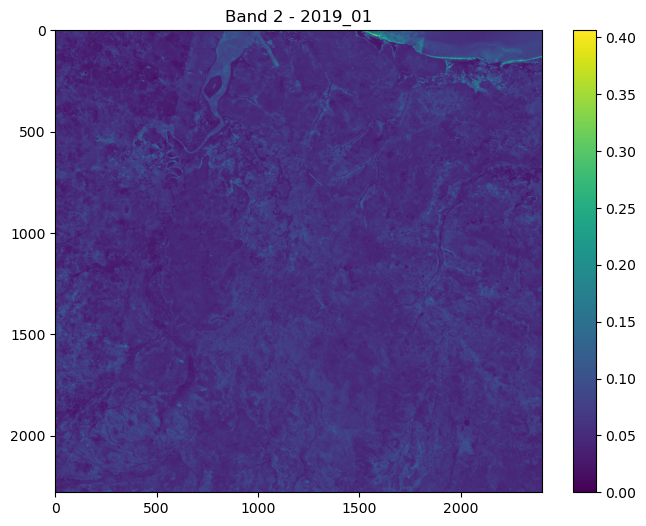

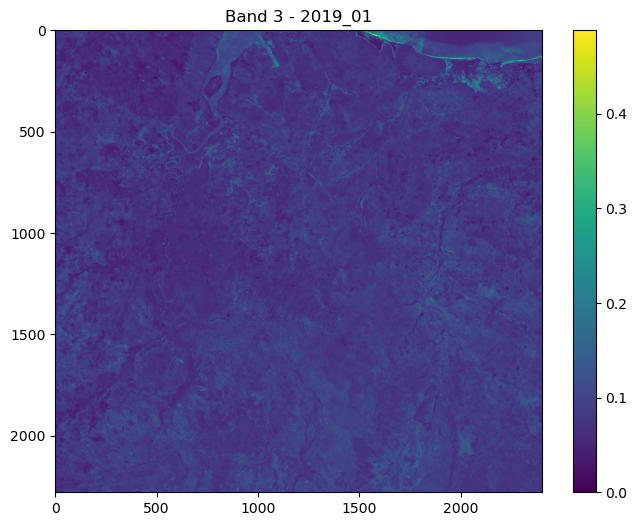

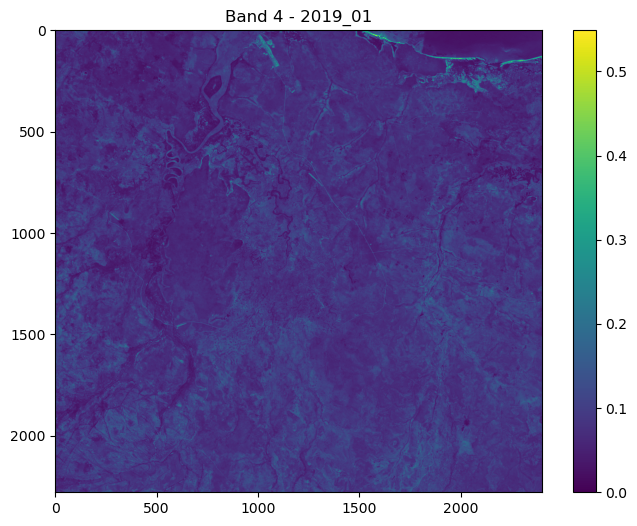

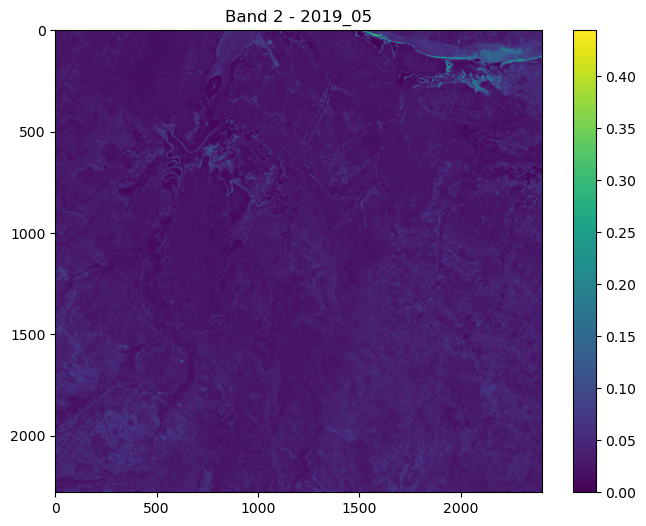

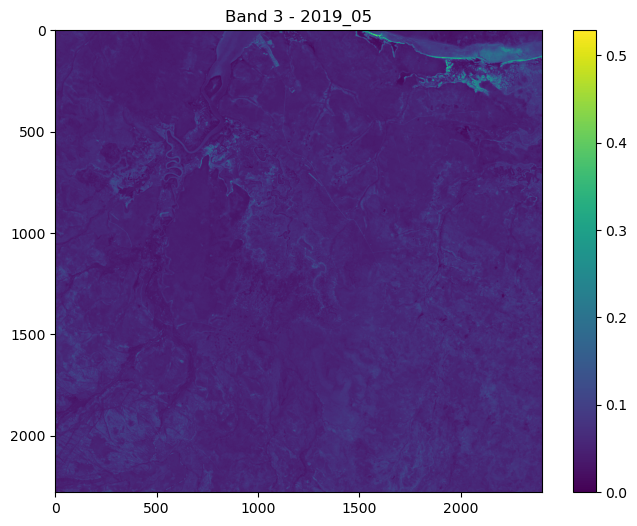

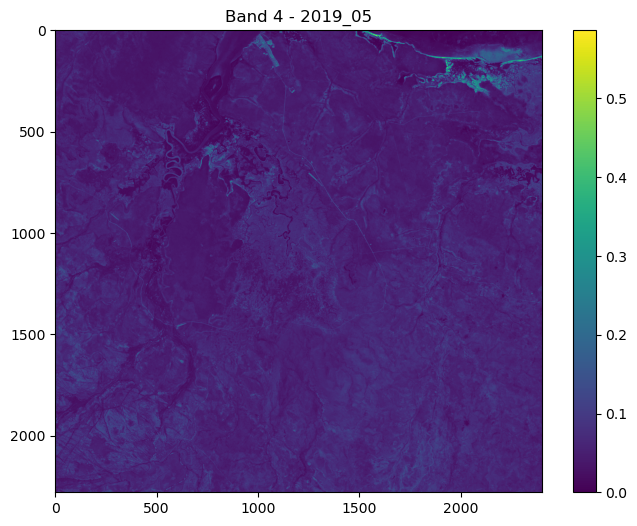

In [ ]:
# Select some bands from the processed data stored in 'data_dict' for plotting
layers_to_plot = []

# Specify the date and band numbers you want to plot
dates_to_plot = ['2019_01', '2019_05']  # This grabs all available dates. You can select specific ones if needed.
bands_to_plot = [1, 2, 3]  # Band indices for bands 2, 3, and 4, which are B, G, and R

# Loop through the selected dates and bands to prepare them for plotting
for date_str in dates_to_plot:
    data = data_dict[date_str]  # Get the normalized data for this date
    
    for band_idx in bands_to_plot:
        # Collect the specific band for plotting
        layers_to_plot.append((data[band_idx], band_idx + 1, date_str))

# Plot the stored layers
for band, band_number, date_str in layers_to_plot:
    plt.figure(figsize=(8, 6))
    plt.imshow(band, cmap='viridis') 
    plt.title(f'Band {band_number} - {date_str}')
    plt.colorbar() #label='Normalized Value'
    plt.show()


### Plot as RGB

We can also visualise the Sentinel-2 bands as an RGB image, using the Red, Green and Blue bands.

The plotting was a bit dark so we will adjust the brightness of the image using a gamma correction.

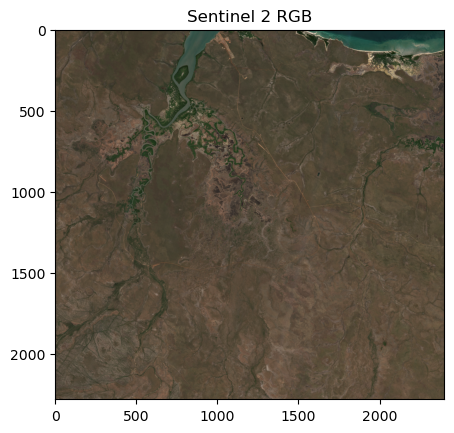

In [76]:
# Specify the date for the RGB layers
date_str = '2019_08'  

# pull out the RGB bands
r_band = data_dict[date_str][3]
g_band = data_dict[date_str][2]
b_band = data_dict[date_str][1]

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Apply gamma correction to the image
gamma = 1.75
rgb_image = rgb_image ** (1/gamma)

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.draw()  # Ensure the plot is rendered
plt.show()
plt.close()  # Close the figure to free memory

### Slope

In [17]:
# Path to the slope raster file
file_path = '../mapping/cropped rasters/slope.tif'

# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_landscape = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    raster_transform = src.transform # same as the raster transform in the NDVI raster read


Slope metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["GDA94 / Geoscience Australia Lambert",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}


Shape of slope landscape raster:
(2280, 2400)


Number of NA values in the slope raster:
9356


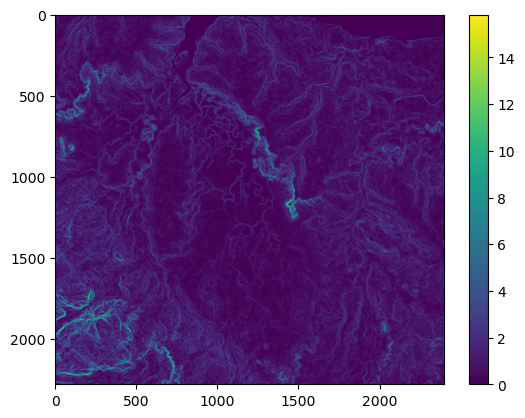

In [19]:
# Check the slope metadata:
print("Slope metadata:")
print(slope_meta)
print("\n")

# Check the shape (rows, columns) of the slope landscape raster:
print("Shape of slope landscape raster:")
print(slope_landscape.shape)
print("\n")

# Check for NA values in the slope raster:
print("Number of NA values in the slope raster:")
print(np.isnan(slope_landscape).sum())

# Replace NaNs in the slope array with 0.0:
slope_landscape = np.nan_to_num(slope_landscape, nan=0.0)

# Define the maximum and minimum slope values from the stack of local layers:
slope_max = 12.2981
slope_min = 0.0006

# Convert the slope landscape data from a NumPy array to a PyTorch tensor:
slope_landscape_tens = torch.from_numpy(slope_landscape)

# Normalize the slope landscape data:
slope_landscape_norm = (slope_landscape_tens - slope_min) / (slope_max - slope_min)

# Visualize the slope landscape (note: displaying the original tensor, not the normalised data):
plt.imshow(slope_landscape_tens.numpy())
plt.colorbar()
plt.show()


### Convert between numpy array and raster

To check that we can go back and forth between numpy arrays (with pixel coordinates) and rasters (with geographic coordinates), we will convert the slope numpy array to a raster. 

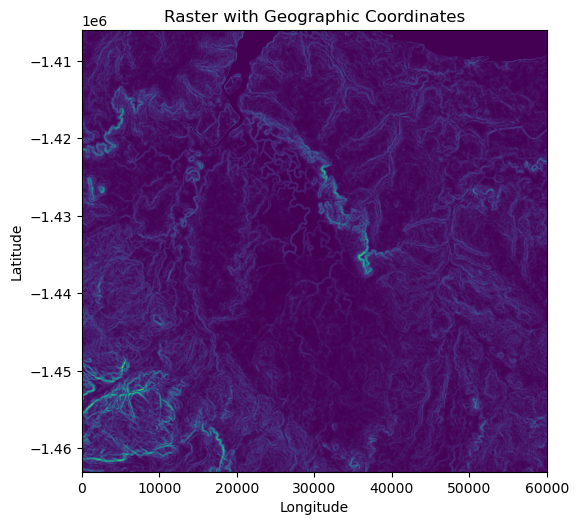

In [25]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(6, 6))

# Convert the slope_landcape (numpy array) to a raster and plot with the rasterio library
rasterio.plot.show(slope_landscape, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

## Subset function

As we described the subset function in the `deepSSF_simulations.ipynb` notebook, and stored it in the `deepSSF_functions.py` script, we will just import it here.

In [162]:
subset_function = deepSSF_utils.subset_raster_with_padding_torch

### Testing the subset function

We want to ensure that the function pads the raster when it is outside the landscape extent.

torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

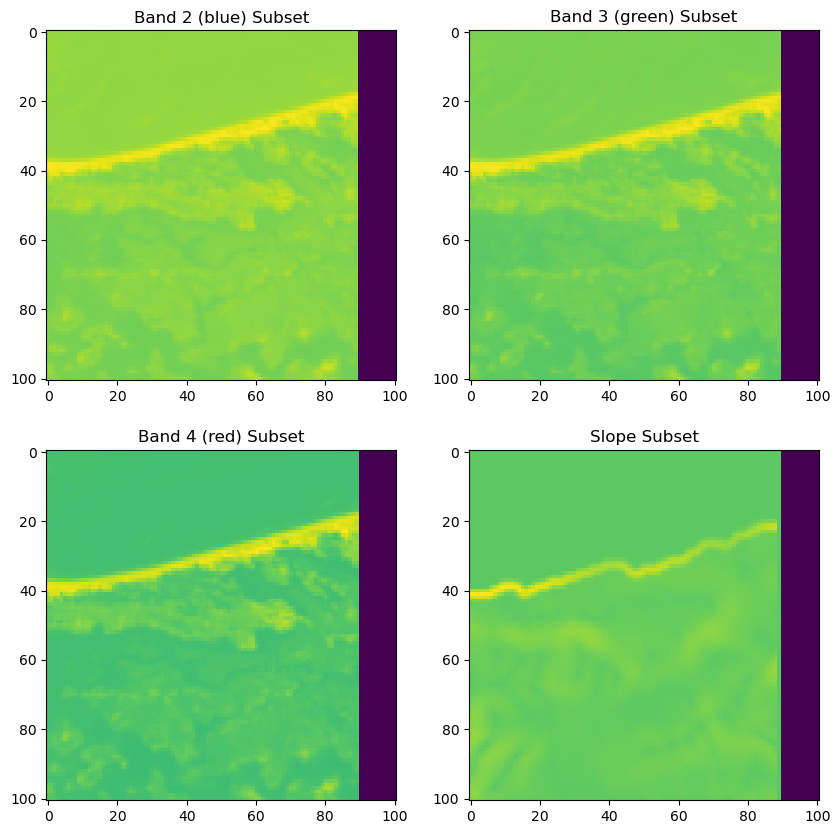

In [163]:
x = 5.9e4
y = -1.41e6
window_size = 101

# Get the subset of the slope landscape
slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

# For sentinel 2 data
selected_month = '2019_01'
# Get the data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape) # [bands, height, width]

# Get the subset of the Sentinel-2 bands
s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.detach().numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')

axs[0, 1].imshow(s2_b3_subset.detach().numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')

axs[1, 0].imshow(s2_b4_subset.detach().numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')

axs[1, 1].imshow(slope_subset.detach().numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')


# Load the model

## Set the device for the model

In [48]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


## Define the parameters for the model

Here we enter the specific parameter values and hyperparameters for the model. 
These are the values that will be used to instantiate the model.

In [49]:
# In our case the 12 Sentinel-2 layers + slope
num_spatial_covs = 13 

params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": num_spatial_covs + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

As described in the `deepSSF_train.ipynb` script, we saved the model definition into a file named `deepSSF_model.py`. We can instantiate the model by importing the file (which was done when importing other packages) and calling the classes parameter dictionary from that script.

In [50]:
params = deepSSF_model.ModelParams(params_dict)
model = deepSSF_model.ConvJointModel(params).to(device)
print(model)

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(17, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128,

## Load the model weights

In [52]:
# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/deepSSF_S2_slope_buffalo2005_2025-02-09.pt', 
                                 map_location=torch.device('cpu'),
                                 weights_only=True))
# print(model.state_dict())
# model.eval()

<All keys matched successfully>

# Setup simulation parameters

To get the simulation running we need a few extra functions. 

Firstly, we need to index the Sentinel-2 layers correctly, based on the time of the simulated location. We'll do this by creating a function that takes day of the year of the simulated location and returns the correct index for the Sentinel-2 layers.

This indexing is slightly different from the indexing we used for the `deepSSF_simulations.ipynb` notebook, which was indexing NDVI layers. In that case we were indexing the layers directly, and therefore the first entry was at 0 (i.e., March was in month_index = 2). Here, we are creating a string that corresponds to the layer name, and therefore the first entry is at 1. (i.e., March will be at month_index = 3)

In [55]:
# Create a mapping from day of the year to month index
def day_to_month_index(day_of_year):
    # Calculate the year and the day within that year
    base_date = datetime(2019, 1, 1)
    date = base_date + timedelta(days=int(day_of_year) - 1)
    year_diff = date.year - base_date.year
    month_index = (date.month) + (year_diff * 12)  # month index (1-based)
    if month_index == 0:
        month_index += 1
    return month_index

yday = 35
month_index = day_to_month_index(yday)
print(month_index)

2


### Check the Sentinel-2 layer indexing

Subset the raster layers at the first observed location of the training data.

Starting x and y coordinates: 43036.55199338104, -1437242.6615283354
Starting day of the year:     271
torch.Size([12, 2280, 2400])


Text(0.5, 1.0, 'Slope Subset')

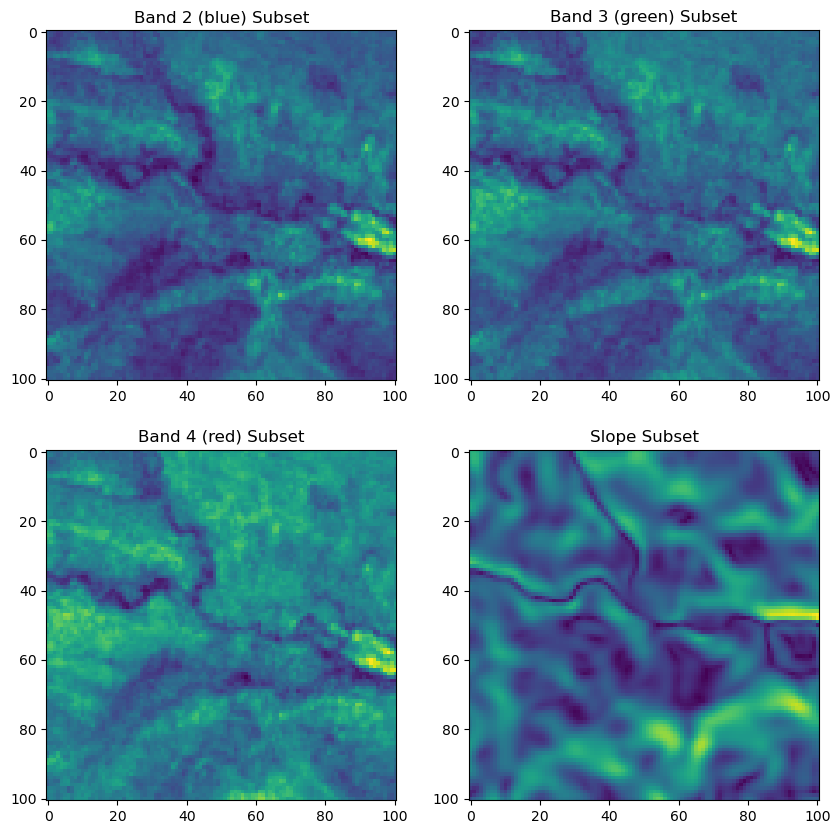

In [164]:
# Set the window size for the local layers 
# (should be the same as the one used during training)
window_size = 101

# Step index for the buffalo data
step_index = 1503

# starting location of buffalo 2005
x = buffalo_df['x1_'].iloc[step_index]
y = buffalo_df['y1_'].iloc[step_index]
print(f'Starting x and y coordinates: {x}, {y}')

yday = buffalo_df['yday_t2'].iloc[step_index]
print(f'Starting day of the year:     {yday}')

# Get the month index from the day of the year
month_index = day_to_month_index(yday)

# for sentinel 2 data
selected_month = f'2019_{month_index:02d}'
# Get the normalized data for the selected month
s2_data = data_dict[selected_month]

# Convert the NumPy array to a PyTorch tensor
s2_tensor = torch.from_numpy(s2_data)
s2_tensor = s2_tensor.float()  # Ensure the tensor is of type float
print(s2_tensor.shape)

# Get the subset of the Sentinel-2 bands
s2_b1_subset, origin_x, origin_y = subset_function(s2_tensor[0,:,:], x, y, window_size, raster_transform)
s2_b2_subset, origin_x, origin_y = subset_function(s2_tensor[1,:,:], x, y, window_size, raster_transform)
s2_b3_subset, origin_x, origin_y = subset_function(s2_tensor[2,:,:], x, y, window_size, raster_transform)
s2_b4_subset, origin_x, origin_y = subset_function(s2_tensor[3,:,:], x, y, window_size, raster_transform)
s2_b5_subset, origin_x, origin_y = subset_function(s2_tensor[4,:,:], x, y, window_size, raster_transform)
s2_b6_subset, origin_x, origin_y = subset_function(s2_tensor[5,:,:], x, y, window_size, raster_transform)
s2_b7_subset, origin_x, origin_y = subset_function(s2_tensor[6,:,:], x, y, window_size, raster_transform)
s2_b8_subset, origin_x, origin_y = subset_function(s2_tensor[7,:,:], x, y, window_size, raster_transform)
s2_b8a_subset, origin_x, origin_y = subset_function(s2_tensor[8,:,:], x, y, window_size, raster_transform)
s2_b9_subset, origin_x, origin_y = subset_function(s2_tensor[9,:,:], x, y, window_size, raster_transform)
s2_b11_subset, origin_x, origin_y = subset_function(s2_tensor[10,:,:], x, y, window_size, raster_transform)
s2_b12_subset, origin_x, origin_y = subset_function(s2_tensor[11,:,:], x, y, window_size, raster_transform)

# Get the subset of the slope landscape
slope_subset, origin_x, origin_y = subset_function(slope_landscape_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(s2_b2_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('Band 2 (blue) Subset')

axs[0, 1].imshow(s2_b3_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Band 3 (green) Subset')

axs[1, 0].imshow(s2_b4_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Band 4 (red) Subset')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')

### Plot as RGB

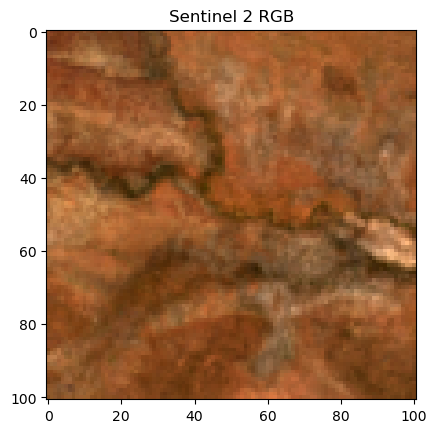

In [165]:
# pull out the RGB bands
r_band = s2_b4_subset.detach().numpy()
g_band = s2_b3_subset.detach().numpy()
b_band = s2_b2_subset.detach().numpy()

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.show()
plt.close()  # Close the figure to free memory

# Next-step function

This function is slightly different from the one we used in the `deepSSF_simulations.ipynb` notebook, mainly due to the indexing and cropping of the Sentinel-2 layers.

The next-step function will take the following inputs:
- environmental rasters at the landscape level,
- the scalar covariates to be turned into grids (temporal covariates in our case),
- the previous bearing to predict the turning angle from,
- the size of the local layer to crop out,
- the current location of the simulated individual,
- the raster transformation to convert between pixel and geographic coordinates.

**Adding jitter to the next step**  
As location of the next step is a particular cell (which are 25 m x 25 m), we also have an additional component in the function that adds an element of randomness to where in the cell the next step is. This prevents the location of the next step from being in exactly the same location as the current step (which would lead to a null bearing and 0 step length), and prevents an artificial grid-like pattern from emerging in the simulated trajectories. As all of the probability values are exactly the same within a cell, this is analogous to the process of simulating from an SSF, where continuous step lengths and turning angles are drawn from their distributions, which land somewhere in a particular cell. However, the difference is that the probability values for the movement kernel in an SSF are still continuous, whereas in the deepSSF model they are discrete (due to calculating the movement probability for each cell). This may lead to artifacts for steps very close to the current location, as the Gamma distribution has high probability near 0.

We 'jitter' the point by adding a small amount of noise in the x and y direction. This small amount is drawn from a 2D (uncorrelated) normal distribution with a mean of 0 and a standard deviation of 6.5 m, such that about 95% of the jittered points will fall within the 25 m x 25 m cell. If the jittered point falls outside of the cell, we re-sample the jittered point until it falls within the cell. 

This could have also been a uniform distribution between -12.5 and 12.5 in the x and y directions, but we chose a normal distribution as for the centre cell we still want it to be close to 0. This was a modelling choice and different choices here will have slightly different effects (although mainly on the step length and turning angle distributions). The cell that was selected, which becomes the cell to start the next step from, will be the same.

In [170]:
def simulate_next_step(sentinel_data_dict,
                        which_month,
                        landscape_raster_tensors, 
                        scalars_to_grid,
                        bearing,
                        window_size, 
                        x_loc, 
                        y_loc,
                        landscape_raster_transform):

    # for sentinel 2 data
    selected_month = f'2019_{which_month:02d}'
    # Get the normalized data for the selected month
    sentinel_layers = sentinel_data_dict[selected_month]
    # print(sentinel_layers.shape)

    # Initialize a list to store the results
    results = []

    # Loop over each layer in sentinel_layers and landscape_raster_tensors
    for sentinel_layer in sentinel_layers:
        # Process the sentinel layer
        sentinel_layer = torch.from_numpy(sentinel_layer)
        # print(sentinel_layer.shape)
        sentinel_result = subset_function(sentinel_layer, 
                                          x=x_loc, 
                                          y=y_loc, 
                                          window_size=window_size, 
                                          transform=landscape_raster_transform)
        results.append(sentinel_result)
    
    for raster_tensor in landscape_raster_tensors:
        # Process the landscape raster tensor
        raster_result = subset_function(raster_tensor, 
                                        x=x_loc, 
                                        y=y_loc, 
                                        window_size=window_size, 
                                        transform=landscape_raster_transform)
        # Append the slope to the Sentinel-2 layers
        results.append(raster_result)
    
    # Unpacking the results
    subset_rasters_tensors, origin_xs, origin_ys = zip(*results)

    # Pull out the RGB bands
    s2_b2_subset = subset_rasters_tensors[1]
    s2_b3_subset = subset_rasters_tensors[2]
    s2_b4_subset = subset_rasters_tensors[3]

    # Pull out the slope
    slope_subset = subset_rasters_tensors[12]
    
    # Stack the processed tensors along a new dimension (e.g., dimension 0)
    x1 = torch.stack(subset_rasters_tensors, dim=0)
    x1 = x1.unsqueeze(0)
    # print(x1.shape)

    # create masking layer to remove outside of the extent
    # where the value is -1, set to NaN (to be masked)
    single_layer = x1[0, 0, :, :]
    mask = torch.where(single_layer == -1, torch.tensor(float('nan')), 1)

    # Scalar data to be converted to a grid
    x2 = scalars_to_grid

    # Bearing data (initialised to 0 but updated at each simulated step)
    x3 = bearing

    # Run the model
    model_output = model((x1, x2, x3))

    # Extract the habitat and movement log probabilities
    hab_log_prob = model_output[:, :, :, 0]
    move_log_prob = model_output[:, :, :, 1]

    # Combine the habitat and movement log probabilities
    step_log_prob = (hab_log_prob + move_log_prob)
    step_log_prob = step_log_prob * mask

    hab_log_prob = hab_log_prob.squeeze()
    move_log_prob = move_log_prob.squeeze()
    step_log_prob = step_log_prob.squeeze()

    # sample from the array values
    step_prob = torch.exp(step_log_prob)
    step_prob = torch.nan_to_num(step_prob, nan=0.)
    step_prob_norm = step_prob/torch.sum(step_prob)

    # Flatten the probability surface
    flat_step_prob_norm = step_prob_norm.flatten().detach().numpy()
    # print(flat_prob_surface)

    # Generate the corresponding indices for the flattened array
    indices = np.arange(flat_step_prob_norm.size)

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_step_prob_norm)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, step_prob_norm.shape)

    # THE Y COORDINATE COMES FIRST in the sampled coordinates
    new_px = origin_xs[0] + sampled_coordinates[1]
    new_py = origin_ys[0] + sampled_coordinates[0]

    # Convert geographic coordinates to pixel coordinates
    new_x, new_y = raster_transform * (new_px, new_py)

    # Sample from a normal distribution with mean 0 and sd 6.5, 
    # which are the parameters where the cell contains ~ 95% of density
    # if it's outside the bounds of the cell, resample
    while True:
        jitter_x = np.random.normal(0, 6.5)
        if -12.5 <= jitter_x <= 12.5:
            break

    # Sample jitter for new_y and ensure it is within bounds
    while True:
        jitter_y = np.random.normal(0, 6.5)
        if -12.5 <= jitter_y <= 12.5:
            break

    # Add the valid jitter to new_x and new_y
    new_x = new_x + jitter_x
    new_y = new_y + jitter_y

    # print(new_x, new_y)

    # Return the new_x and new_y coordinates, 
    # the probability surfaces for optional plotting,
    # and the sampled coordinates (next step in local layer pixel coordinates)
    return new_x, \
           new_y, \
           hab_log_prob, \
           move_log_prob, \
           step_log_prob, \
           sampled_coordinates[1], \
           sampled_coordinates[0], \
           s2_b2_subset, \
           s2_b3_subset, \
           s2_b4_subset, \
           slope_subset


## Test the function

Hour of the day:                                    17
Day of the year:                                    270
Bearing at the step:                                3.007
New location in local layer pixel coordinates:      (78, 57)
New location in geographic coordinates:             (43722.52314239582, -1437432.4921920316)


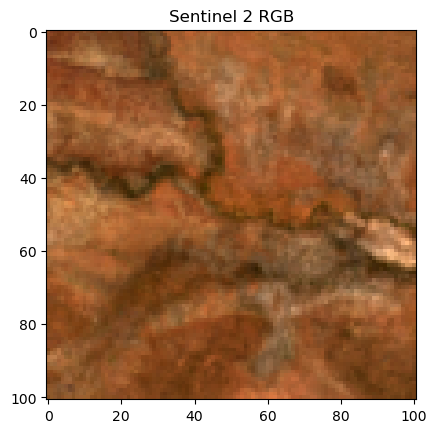

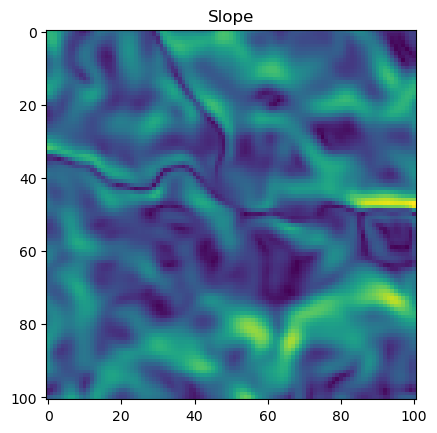

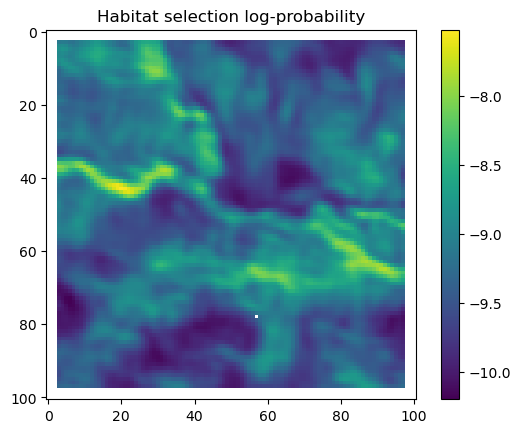

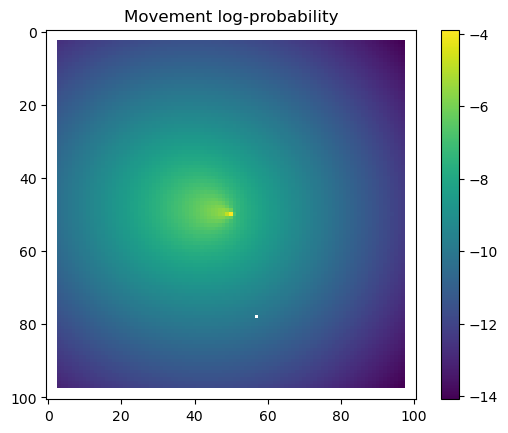

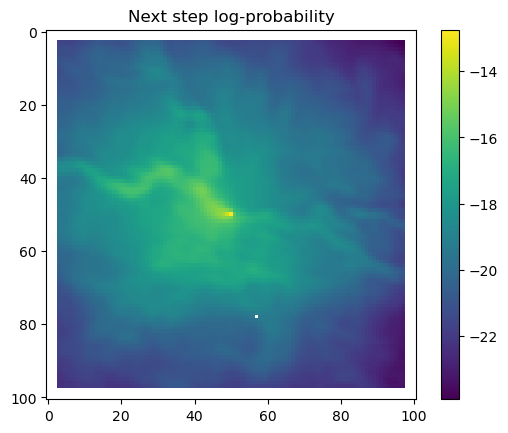

In [171]:
# Rasters besides the Sentinel-2 bands
landscape_raster_list = [slope_landscape_norm]

x2 = torch.stack((torch.tensor(buffalo_df['hour_t2_sin'].iloc[step_index]).float(), 
                  torch.tensor(buffalo_df['hour_t2_cos'].iloc[step_index]).float(),
                  torch.tensor(buffalo_df['yday_t2_sin'].iloc[step_index]).float(),
                  torch.tensor(buffalo_df['yday_t2_cos'].iloc[step_index]).float()), dim=0).unsqueeze(0)

# Debugging prints
# print(x2)
# print(x2.shape)

# recover the hour value for the step
hour_t2 = int(deepSSF_utils.recover_hour(buffalo_df['hour_t2_sin'].iloc[step_index], 
                                         buffalo_df['hour_t2_cos'].iloc[step_index]))
print(f'Hour of the day:                                    {hour_t2}')

# recover the day of the year value for the step
yday_t2 = int(deepSSF_utils.recover_yday(buffalo_df['yday_t2_sin'].iloc[step_index], 
                                         buffalo_df['yday_t2_cos'].iloc[step_index]))
print(f'Day of the year:                                    {yday_t2}')

# Pull out the bearing
bearing = buffalo_df['bearing'].iloc[step_index]
bearing_step = torch.tensor(bearing).float().unsqueeze(0).unsqueeze(0)
print(f'Bearing at the step:                                {round(bearing, 3)}')

# Debugging prints
# print(bearing_step)
# print(bearing_step.shape)

# Simulate the next step
test_outputs = simulate_next_step(sentinel_data_dict=data_dict,
                                    which_month=month_index,
                                    landscape_raster_tensors=landscape_raster_list,
                                    scalars_to_grid=x2,
                                    bearing=bearing_step,
                                    window_size=101,
                                    x_loc=x, # x location defined above
                                    y_loc=y, # y location defined above
                                    landscape_raster_transform=raster_transform)

# Unpack the test outputs
(new_x, new_y, 
 hab_log_prob, move_log_prob, step_log_prob, 
 px, py, 
 s2_b2_subset, s2_b3_subset, s2_b4_subset, 
 slope_subset) = test_outputs

print(f'New location in local layer pixel coordinates:      {px, py}')
print(f'New location in geographic coordinates:             {new_x, new_y}')

# Create the mask for edge cells 
# (as the convolution filters create artifacts due to the padding)
x_mask = np.ones_like(hab_log_prob.detach().numpy())
y_mask = np.ones_like(hab_log_prob.detach().numpy())

# mask out cells on the edges that affect the colour scale
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

# Set the pixel of the next step, which is at (px, py) to -inf
hab_log_prob[(px, py)] = -np.inf
move_log_prob[(px, py)] = -np.inf
step_log_prob[(px, py)] = -np.inf

# Plot the RGB bands
# Grab the RGB bands from the model output above
r_band = s2_b4_subset.detach().numpy()
g_band = s2_b3_subset.detach().numpy()
b_band = s2_b2_subset.detach().numpy()

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure()  # Create a new figure
plt.imshow(rgb_image)
plt.title('Sentinel 2 RGB')
plt.show()
plt.close()  

plt.figure()  # Create a new figure
plt.imshow(slope_subset.detach().numpy())
plt.title('Slope')
plt.show()
plt.close()  

# Plot the habitat selection log-probability after applying the border mask
plt.imshow(hab_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Habitat selection log-probability')
plt.show()
plt.close()  

# Plot the movement log-probability
plt.imshow(move_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Movement log-probability')
plt.show()
plt.close()  

# Plot the next step log-probability with the masks applied.
plt.imshow(step_log_prob.detach().numpy()[:,:] * x_mask * y_mask)
plt.colorbar()
plt.title('Next step log-probability')
plt.show()
plt.close()  

# Generate trajectory

Now we can loop over the next-step function to generate a trajectory.

## Setup parameters

In [209]:
# Setup the simulation parameters
n_steps = 3000

# Size of the local layers
window_size = 101

# Starting location and yday of buffalo 2005 (training data)
start_x = buffalo_df['x1_'].iloc[0]
start_y = buffalo_df['y1_'].iloc[0]
starting_yday = buffalo_df['yday_t2'].iloc[0]

print(f'Starting x and y coordinates: {start_x}, {start_y}')
print(f'Starting day of the year:     {starting_yday}')

landscape_raster_list = [slope_landscape_norm]
landscape_raster_transform = raster_transform

# output directory for saving plots
output_dir = f'outputs/deepSSF_prob_maps/S2/{buffalo_id}'
os.makedirs(output_dir, exist_ok=True)

Starting x and y coordinates: 41969.3108749757, -1435671.1517590766
Starting day of the year:     206


## Create simulation inputs from the parameters

Create empty lists to store the simulated locations and bearings, and initialise the vectors of temporal covariates.

In [210]:
# Empty lists to store the x and y coordinates
x = np.repeat(0., n_steps)
y = np.repeat(0., n_steps)

# Set the first entry as the starting location
x[0], y[0] = start_x, start_y

# Create an hour-of-day sequence and repeat it until it reaches n_steps.
hour_t2 = np.resize(range(24), n_steps)

# Convert hour-of-day values into sine and cosine components.
hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

# Create the day of the year sequences 
# We want to index the NDVI layers into next year, which is why the ydays go above 365
yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)
yday_t2 = np.resize(yday_t2, n_steps)

# Convert day-of-year values into sine and cosine components.
yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

# Initialise a bearing vector with zeroes for all simulation steps, 
# which will be updated during the simulation.
bearing = np.repeat(0., n_steps)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
yday_t2_tensor = torch.tensor(yday_t2).float()
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
bearing_tensor = torch.tensor(bearing).float()

# Stack tensors column-wise to create a tensor of shape [n_steps, 4]
x2_full = torch.stack((hour_t2_sin_tensor, 
                       hour_t2_cos_tensor, 
                       yday_t2_sin_tensor, 
                       yday_t2_cos_tensor), dim=1)

# Initialize variables to cache the previous yday and month index
previous_yday = None

# Trajectory loop

Now we can loop over the next-step function to generate a trajectory. Essentially we have to a some starting location, which goes through the `simulate_next_step` function to get the next location, which then becomes the current location for the next step.

For indexing, the location we are trying to predict (the next step) is index `i`, and the current location is index `i-1`. This prevents the loop from breaking by storing the final location at `i+1`, which is outside of the loop range.

The bearing at `i-1` is the bearing between `i-1` and `i-2`, i.e., the bearing that location `i-1` was approached from.

After the `simulate_next_step` function, we have some code for generating and saving plots of the habitat selection, movement and next-step predictions (all on the log-scale as they're more informative). This is helpful to check that everything is working as expected, but can also be used for making animations (when plotting the surfaces for the whole trajectory). When making a trajectory it can be helpful to comment out the `plt.show()` lines, so the plots will just save to file and not pop up.

In [ ]:
for i in range(1, n_steps):

    x_loc = x[i-1]
    y_loc = y[i-1]

    # calculate the bearing from the previous location
    if i > 1:
        bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
    else:
        # if it's the first step, sample a random bearing
        bearing_rad = np.random.uniform(-np.pi, np.pi)

    # Store the bearing in the vector
    bearing[i-1] = bearing_rad
    # print("Bearing[i-1]", bearing[i-1])

    # Convert the bearing to a tensor and add dimensions for the batch and channel
    bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)
    # print(bearing_tensor.shape) # Debugging print

    # Select the temporal features for the specific step
    x2 = x2_full[i-1,:].unsqueeze(dim=0)
    # print(x2)
    
    # Determine the month index based on the day of the year
    day_of_year = yday_t2[i-1] % 365
    if day_of_year != previous_yday:
        month_index = day_to_month_index(day_of_year)
        previous_yday = day_of_year

    # print(f'Day of the year: {day_of_year}') # Debugging print
    # print(f'Month index: {month_index}') # Debugging print

    # Landscape rasters besides the Sentinel-2 bands
    landscape_raster_list = [slope_landscape_norm]
    
    # Run the simulation for the next step
    sim_outputs = simulate_next_step(sentinel_data_dict=data_dict,
                                      which_month=month_index,
                                      landscape_raster_tensors=landscape_raster_list,
                                      scalars_to_grid=x2,
                                      bearing=bearing_tensor,
                                      window_size=window_size,
                                      x_loc=x_loc,
                                      y_loc=y_loc,
                                      landscape_raster_transform=landscape_raster_transform)
    
    (new_x, new_y, 
     hab_log_prob, move_log_prob, step_log_prob, 
     px, py, 
     s2_b2, s2_b3, s2_b4,
     slope_subset) = sim_outputs
    # print(f'New location in pixel coordinates           {px, py}') # Debugging print
    # print(f'New location in geographic coordinates      {new_x, new_y}\n') # Debugging print

    x[i] = new_x
    y[i] = new_y
    
    
    # -------------------------------------------------------------------------
    # Plot the probability surfaces for habitat selection, movement, and next step
    # -------------------------------------------------------------------------

    # The x_mask and y_mask objects should have already been defined earlier in the code

    # Plot the first few probability surfaces - change the condition to i < n_steps to plot all
    if i < 250:
        
        # pull out the RGB bands
        r_band = s2_b4.detach().numpy()
        g_band = s2_b3.detach().numpy()
        b_band = s2_b2.detach().numpy()

        # Stack the bands along a new axis
        rgb_image = np.stack([r_band, g_band, b_band], axis=-1)
        # Normalize to the range [0, 1] for display
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())


        ## Habitat probability surface
        hab_log_prob = hab_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        hab_log_prob[py, px] = -np.inf

        ## Movement probability surface
        move_log_prob = move_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        move_log_prob[py, px] = -np.inf

        ## Next step probability surface
        next_step_log = step_log_prob.detach().numpy()[:,:] * x_mask * y_mask
        next_step_log[py, px] = -np.inf

        # -------------------------------------------------------------------------
        # Plot the RGB image, slope, habitat selection, and movement density
        #   Change the panels to visualize different layers
        # -------------------------------------------------------------------------
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        # Plot RGB
        im1 = axs[0, 0].imshow(rgb_image)
        axs[0, 0].set_title('Sentinel-2 RGB')

        # Plot slope
        im2 = axs[0, 1].imshow(slope_subset.detach().numpy(), cmap='viridis')
        axs[0, 1].set_title('Slope')
        fig.colorbar(im2, ax=axs[0, 1], shrink=0.7)

        # Plot habitat selection
        im3 = axs[1, 0].imshow(hab_log_prob, cmap='viridis')
        axs[1, 0].set_title('Habitat selection log-probability')
        fig.colorbar(im3, ax=axs[1, 0], shrink=0.7)

        # # Movement density (change the axis and uncomment one of the other panels)
        # im3 = axs[1, 0].imshow(move_log_prob, cmap='viridis')
        # axs[1, 0].set_title('Movement log-probability')
        # fig.colorbar(im3, ax=axs[0, 1], shrink=0.7)

        # Next-step probability
        im4 = axs[1, 1].imshow(next_step_log, cmap='viridis')
        axs[1, 1].set_title('Next-step log-probability')
        fig.colorbar(im4, ax=axs[1, 1], shrink=0.7)

        # Save the figure
        filename_covs = f'{output_dir}/sim_S2_id{buffalo_id}_{today_date}_{i}.png'
        plt.tight_layout()
        plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
        # plt.show()
        plt.close()  # Close the figure to free memory



## Plot the simulated trajectory

3000


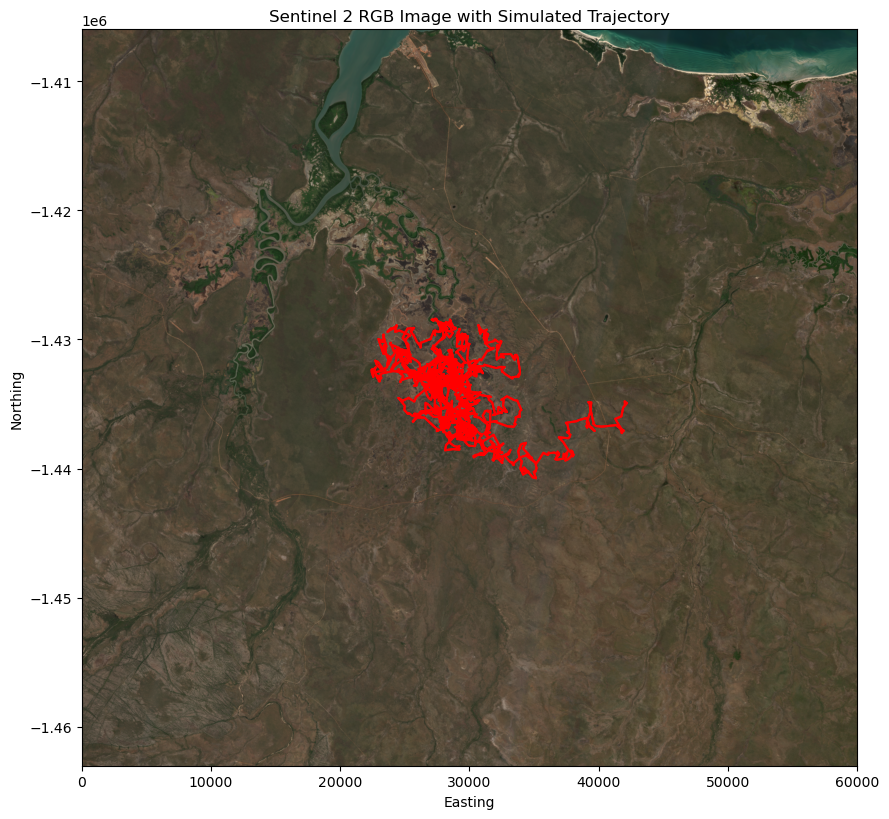

In [ ]:
# Create a figure and axis with matplotlib
# fig, ax = plt.subplots(figsize=(7.5, 7.5))

# plot RGB from the sentinel layers as the background
month_index = day_to_month_index(starting_yday)
selected_month = f'2019_{month_index:02d}'
# Get the normalized data for the selected month
sentinel_layers = data_dict[selected_month]

# pull out the RGB bands
r_band = sentinel_layers[3,:,:]
g_band = sentinel_layers[2,:,:]
b_band = sentinel_layers[1,:,:]

# Stack the bands along a new axis
rgb_image = np.stack([r_band, g_band, b_band], axis=0)
# Normalize to the range [0, 1] for display
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Apply gamma correction to the image
gamma = 1.75
rgb_image = rgb_image ** (1/gamma)

# Plot the raster
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

show(rgb_image, transform=raster_transform, ax=ax)

# Set the title and labels
ax.set_title('Sentinel 2 RGB Image with Simulated Trajectory')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')

# Number of simulated locations (to just get valid points)
n_sim_points = np.min([x[x>0].shape[0], y[y<0].shape[0]])
print(n_sim_points)

# Plot the simulated trajectory
plt.plot(x[1:n_sim_points], y[1:n_sim_points], color = 'red')
plt.plot(x[1:n_sim_points], y[1:n_sim_points], color = 'red')
plt.show()


# Plot with interactive map

We can also use the `folium` library to plot the trajectory on an interactive map. This is useful for checking the trajectory in more detail, as we can zoom in and out and pan around the map.

We used the ESRI World Imagery basemap, although other basemaps can be used (check the `folium` documentation for more options: https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html).

### Change the projection of the trajectory

The `folium` maps use the World Geodetic System 1984 (WGS84) that used latitude and longitute coordinates, denoted by EPSG:4326 as the projection. We will therefore need to reproject the observed data to that projection if we want to plot it.

We use the `pyproj` library to reproject the data. 

In [ ]:
# Create the reprojection function (input CRS: EPSG 3112, output CRS: EPSG 4326)
coord_transformer = Transformer.from_crs('epsg:3112', 'epsg:4326')

# Observed data
# Convert the easting and northing coordinates to geographic coordinates
buffalo_lon, buffalo_lat = coord_transformer.transform(buffalo_df['x_'], buffalo_df['y_'])
print(buffalo_lon[0:2], buffalo_lat[0:2])
# Create a list of coordinate pairs (rather than separate lists)
buffalo_coordinates = [[lon, lat] for lon, lat in zip(buffalo_lon, buffalo_lat)]
print(buffalo_coordinates[0:2])

# Simulated data
# Convert the easting and northing coordinates to geographic coordinates
sim_lon, sim_lat = coord_transformer.transform(x[x>0], y[x>0])
# Create a list of coordinate pairs
sim_coordinates = [[lon, lat] for lon, lat in zip(sim_lon, sim_lat)]

[-12.299553  -12.2994049] [134.3782029 134.3777718]
[[-12.299552999999989, 134.3782029], [-12.29940489999998, 134.3777718]]


## Create the basemap

In [ ]:
# ESRI World Imagery basemap tile
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'

# Create a folium map with the ESRI World Imagery basemap (centred on starting location)
basemap = folium.Map(location=buffalo_coordinates[0], tiles=tiles, attr='Esri', zoom_start = 10)

## Show the basemap with the trajectories

Because the simulated trajectories are stochastic they won't line up with the observed trajectory, but plotting the data should reveal general patterns and relationships to environmental features.

In [ ]:
# Add the buffalo data
folium.PolyLine(
    locations=buffalo_coordinates,
    color='red',
    weight=2,
    opacity=1,
    tooltip='Buffalo trajectory'
).add_to(basemap)

# Add the simulated data
folium.PolyLine(
    locations=sim_coordinates,
    color='blue',
    weight=2,
    opacity=1,
    tooltip='Simulated trajectory'
).add_to(basemap)

# Plot the map
basemap

## Write the trajectory to a csv

### Only run this once otherwise it will create duplicates

In [ ]:
# output directory for saving trajectories
output_dir_traj = f'outputs/deepSSF_trajectories/S2/{buffalo_id}'
os.makedirs(output_dir_traj, exist_ok=True)

# Combine vectors into a DataFrame
trajectory_df = pd.DataFrame({'x': x[x>0], 
                              'y': y[x>0], 
                              'hour': hour_t2[x>0], 
                              'yday': yday_t2[x>0], 
                              'bearing': bearing[x>0]})

n_steps_actual = x[x>0].shape[0]

# Save the DataFrame to a CSV file
index = 1
csv_filename = f'{output_dir_traj}/deepSSF_S2_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

# Check if the file already exists and find a new name if necessary
while os.path.exists(csv_filename):
    csv_filename = f'{output_dir_traj}/deepSSF_S2_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
    index += 1

print(csv_filename)
trajectory_df.to_csv(csv_filename, index=True)

outputs/deepSSF_trajectories/S2/2005/deepSSF_S2_id2005_3000steps_1_2025-02-10.csv


## Multiple trajectories in a loop

In [ ]:
# -------------------------------------------------------------------------
# Setup parameters
# -------------------------------------------------------------------------
n_trajectories = 50
n_steps = 3000
starting_yday = 206

# -------------------------------------------------------------------------
# Looping over simulated individuals
# -------------------------------------------------------------------------

for j in range(1, n_trajectories+1):

    # Empty lists to store the x and y coordinates
    x = np.repeat(0., n_steps)
    y = np.repeat(0., n_steps)

    # Set the first entry as the starting location
    x[0], y[0] = start_x, start_y

    # Create sequence of steps
    step = range(1, n_steps)

    # Create an hour-of-day sequence and repeat it until it reaches n_steps.
    hour_t2 = np.resize(range(24), n_steps)

    # Convert hour-of-day values into sine and cosine components.
    hour_t2_sin = np.sin(2 * np.pi * hour_t2 / 24)
    hour_t2_cos = np.cos(2 * np.pi * hour_t2 / 24)

    # Create the day of the year sequences 
    # We want to index the NDVI layers into next year, which is why the ydays go above 365
    yday_t2 = np.repeat(range(starting_yday, starting_yday + 365), 24)
    yday_t2 = np.resize(yday_t2, n_steps)

    # Convert day-of-year values into sine and cosine components.
    yday_t2_sin = np.sin(2 * np.pi * yday_t2 / 365)
    yday_t2_cos = np.cos(2 * np.pi * yday_t2 / 365)

    # Initialise a bearing vector with zeroes for all simulation steps, 
    # which will be updated during the simulation.
    bearing = np.repeat(0., n_steps)

    # Convert lists to PyTorch tensors
    hour_t2_tensor = torch.tensor(hour_t2).float()
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float()
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float()
    yday_t2_tensor = torch.tensor(yday_t2).float()
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float()
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float()  
    bearing_tensor = torch.tensor(bearing).float()

    # Stack tensors column-wise to create a tensor of shape [n_steps, 4]
    x2_full = torch.stack((hour_t2_sin_tensor, 
                           hour_t2_cos_tensor, 
                           yday_t2_sin_tensor, 
                           yday_t2_cos_tensor), dim=1)

    # Initialize variables to cache the previous yday and month index
    previous_yday = None


    # -------------------------------------------------------------------------
    # Simulation loop
    # -------------------------------------------------------------------------
    
    for i in range(1, n_steps):

        x_loc = x[i-1]
        y_loc = y[i-1]

        # calculate the bearing from the previous location
        if i > 1:
            bearing_rad = np.arctan2(y[i-1] - y[i-2], x[i-1] - x[i-2])
        else:
            # if it's the first step, sample a random bearing
            bearing_rad = np.random.uniform(-np.pi, np.pi)

        # Store the bearing in the vector
        bearing[i-1] = bearing_rad
        # print("Bearing[i-1]", bearing[i-1]) # Debugging print

        # Convert the bearing to a tensor and add dimensions for the batch and channel
        bearing_tensor = torch.tensor(bearing[i-1]).unsqueeze(0).unsqueeze(0)
        # print(bearing_tensor.shape) # Debugging print

        # Select the temporal features for the specific step
        x2 = x2_full[i-1,:].unsqueeze(dim=0)
        # print(x2) # Debugging print

        # Determine the month index based on the day of the year
        day_of_year = yday_t2[i-1]  % 365
        if day_of_year != previous_yday:
            month_index = day_to_month_index(day_of_year)
            previous_yday = day_of_year

        # print(f'Day of the year: {day_of_year}') # Debugging print
        # print(f'Month index: {month_index}') # Debugging print

        # Landscape rasters besides the Sentinel-2 bands
        landscape_raster_list = [slope_landscape_norm]
        
        sim_outputs = simulate_next_step(sentinel_data_dict=data_dict,
                                        which_month=month_index,
                                        landscape_raster_tensors=landscape_raster_list,
                                        scalars_to_grid=x2,
                                        bearing=bearing_tensor,
                                        window_size=window_size,
                                        x_loc=x_loc,
                                        y_loc=y_loc,
                                        landscape_raster_transform=landscape_raster_transform)
        
        (new_x, new_y, 
        hab_log_prob, move_log_prob, step_log_prob, 
        px, py, 
        s2_b2, s2_b3, s2_b4,
        slope_subset) = sim_outputs
        # print(f'New location in pixel coordinates           {px, py}') # Debugging print
        # print(f'New location in geographic coordinates      {new_x, new_y}\n') # Debugging print

        x[i] = new_x
        y[i] = new_y


    # -------------------------------------------------------------------------
    # Save the simulated trajectories
    # -------------------------------------------------------------------------

    # save the data frames individually
    # Combine vectors into a DataFrame
    trajectory_df = pd.DataFrame({'x': x[x>0], 
                                  'y': y[x>0], 
                                  'hour': hour_t2[x>0], 
                                  'yday': yday_t2[x>0], 
                                  'bearing': bearing[x>0]})
    
    n_steps_actual = x[x>0].shape[0]

    # Save the DataFrame to a CSV file
    index = j
    csv_filename = f'{output_dir_traj}/deepSSF_S2_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'

    # Check if the file already exists and find a new name if necessary
    while os.path.exists(csv_filename):
        csv_filename = f'{output_dir_traj}/deepSSF_S2_id{buffalo_id}_{n_steps_actual}steps_{index}_{today_date}.csv'
        index += 1

    print(csv_filename)
    trajectory_df.to_csv(csv_filename, index=True)


outputs/deepSSF_trajectories/S2/2005/deepSSF_S2_id2005_3000steps_2_2025-02-10.csv


KeyboardInterrupt: 